# STROKE DATA EXPLORATION

# 1. Import library and load dataset

In [98]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
import seaborn
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)
seed = 4
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=seed)

# 2. Summarize Data

## 2.1) Descriptive statistics

### View few first rows

In [78]:
data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


### Dimensions of data

In [79]:
data.shape

(5110, 11)

### Data type of each attribute

In [80]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Statistical summary

In [81]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,43.227,0.097,0.054,106.148,28.893,0.049
std,22.613,0.297,0.226,45.284,7.854,0.215
min,0.080,0.000,0.000,55.120,10.300,0.000
25%,25.000,0.000,0.000,77.245,23.500,0.000
50%,45.000,0.000,0.000,91.885,28.100,0.000
75%,61.000,0.000,0.000,114.090,33.100,0.000
max,82.000,1.000,1.000,271.740,97.600,1.000


We pay attention to the `bmi` attribute which has 4909 observations summarized whereas other attributes have 5110 observations. This imply `bmi` might have missing values.

### Class distribution

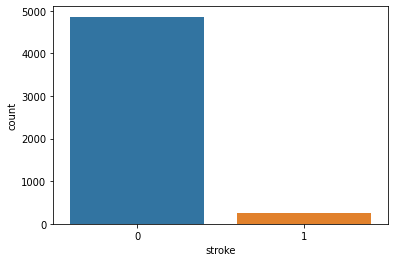

In [82]:
seaborn.countplot(x='stroke', data=data)
pyplot.savefig("./exploration_figures/class_distribution.png")
pyplot.show()

In [83]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Our dataset is severely imbalanced: $\frac{\text{#stroke}}{\text{#not stroke}} = \frac{1}{20}$

### Identify Columns That Have Very Few Values

In [84]:
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
print("Number of unique values in each columns")
print("{:<20}{:>8}{:>12}\t {}".format("Column", "n_unique", "Percentage", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in data.columns:
    percentage = n_uniques[col] / data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (data[col].unique() if percentage < 1 else ""))

Number of unique values in each columns
Column              n_unique  Percentage	 Unique values
-----------------------------------------------------------------------------------------
gender                     3         0.1%	 ['Male' 'Female' 'Other']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3979        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke                     2         0.0%	 [1 0]


### Distinguish Numerical and Categorical Features

In [99]:
# Remove outlier associated with `age` (only 1 outlier)

data = data[data['gender'] != "Other"]

# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)


Categorical: ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
Numerical: ['age', 'avg_glucose_level', 'bmi']


Luckily, we don't have any single-value columns.

### Count number of missing values

In [85]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


Looking at the above table and unique values of each column, we could tell *bmi* has 201 missing values.


## 2.2) Data visualizations

### Univariate Plots

#### Histograms

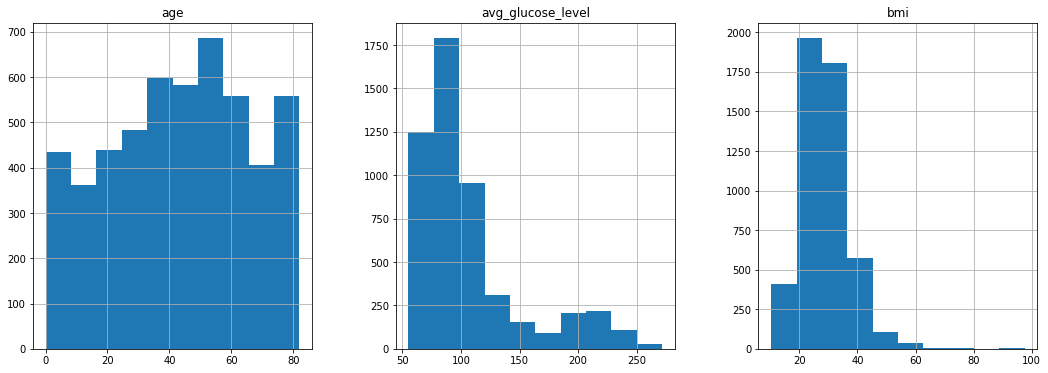

In [86]:
data[numerical_ix].hist(figsize=(18, 6), layout=(1, 3))
pyplot.show()

#### Density Plots

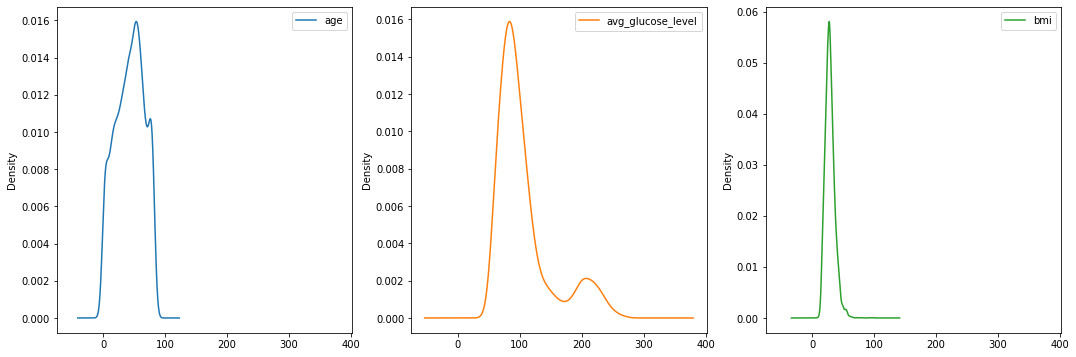

In [87]:
data[numerical_ix].plot(kind='density', subplots=True, layout=(1,3), figsize=(18, 6))
pyplot.show()

#### Box and Whisker Plots

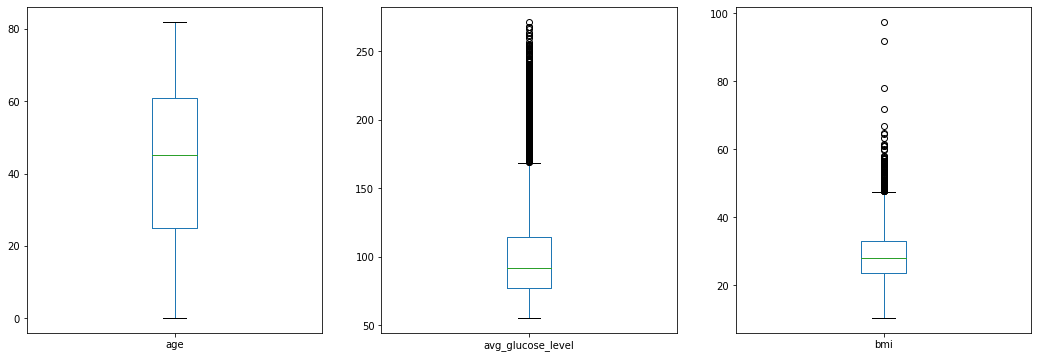

In [88]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.savefig("./exploration_figures/boxplot_before.png")
pyplot.show()

#### Bar Plots

<Figure size 1584x1584 with 0 Axes>

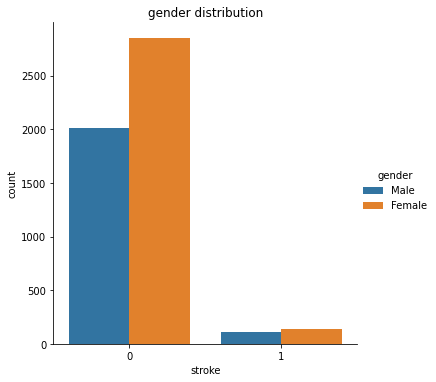

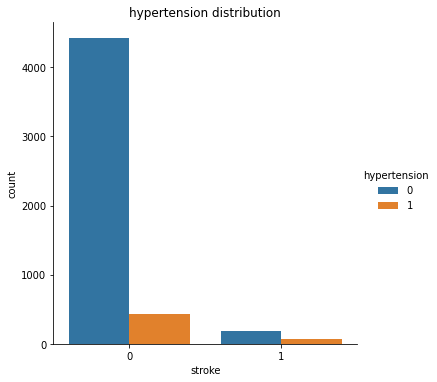

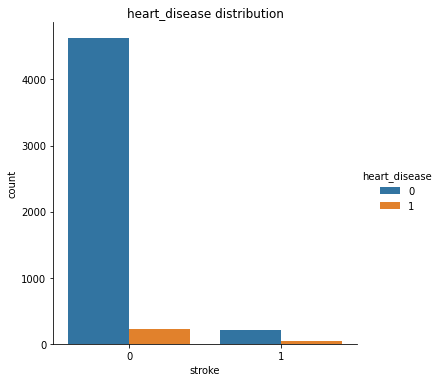

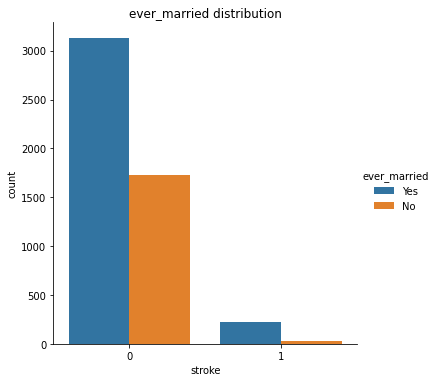

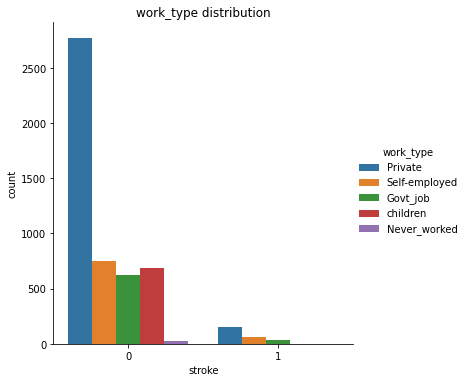

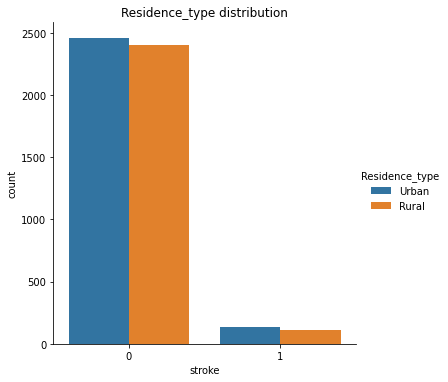

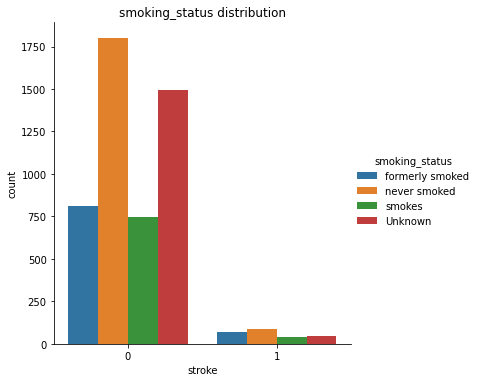

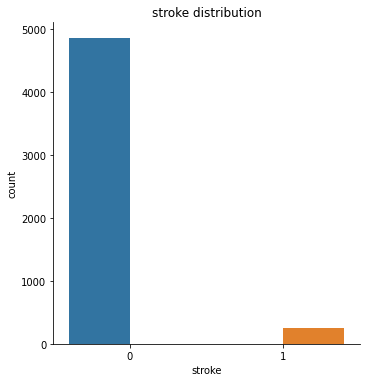

In [89]:
pyplot.figure(figsize=(22, 22))
for i in range(len(categorical_ix)):
    # pyplot.subplot(3, 3, i + 1)
    seaborn.catplot(x='stroke', kind='count', data=data, hue=categorical_ix[i])
    pyplot.title(categorical_ix[i] + ' distribution')
pyplot.show()

### Multivariate Plots

#### Correlation Matrix Plot

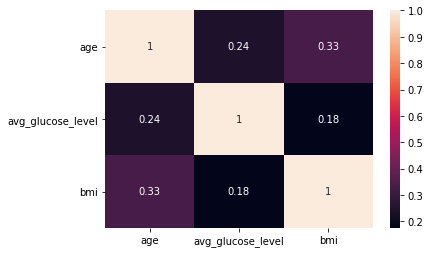

In [90]:
correlations = data[numerical_ix].corr(method='pearson')
seaborn.heatmap(correlations, annot=True)
pyplot.show()

#### Pair Plots

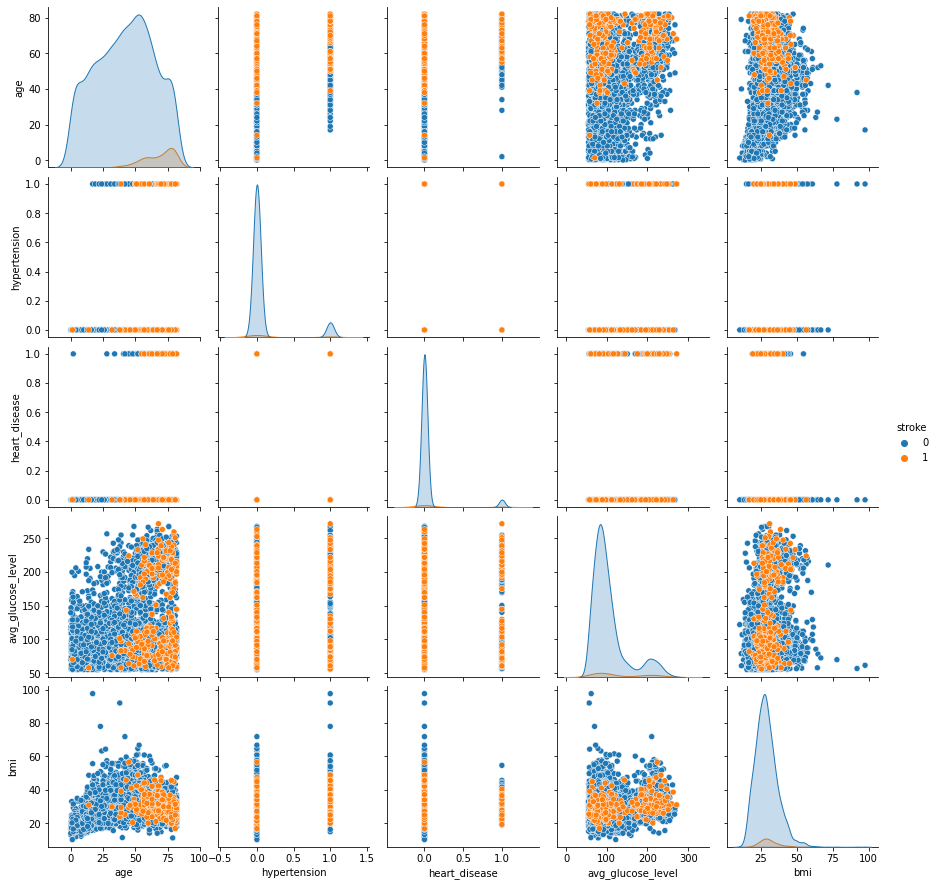

In [91]:
seaborn.pairplot(data.sort_values('stroke'), hue='stroke')
pyplot.savefig("./exploration_figures/pairplot.png")
pyplot.show()

### Look for outliers on numerical features

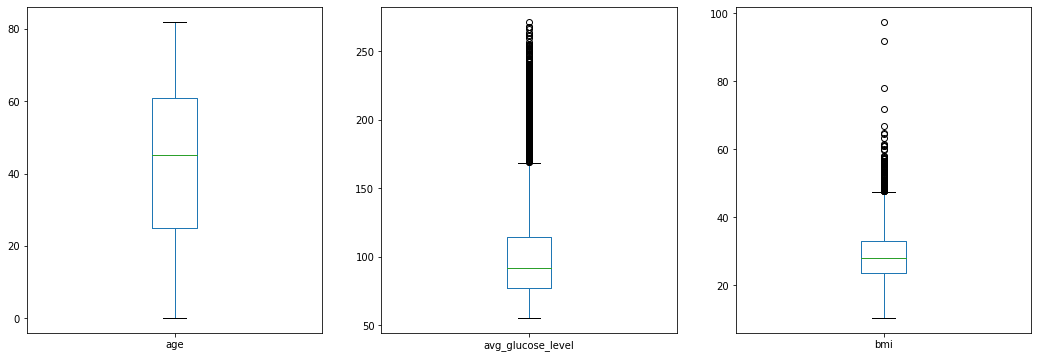

,age,avg_glucose_level,bmi
count,5109.000,5109.000,4908.000
mean,43.230,106.140,28.895
std,22.614,45.285,7.854
min,0.080,55.120,10.300
25%,25.000,77.240,23.500
50%,45.000,91.880,28.100
75%,61.000,114.090,33.100
max,82.000,271.740,97.600


In [92]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

data[numerical_ix].describe()

By looking at the table, box plot and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70

#### Outlier Detection By Quantile Range

Factor 4 of IQR from quantile 75th seems to be a reasonable boundary with *bmi* values.

If you want to use this method, run the code block below

UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


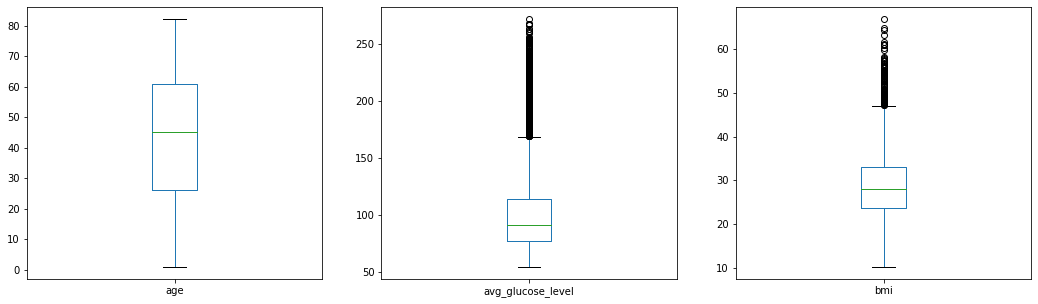

<ipython-input-93-45550baa8e2d>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seaborn.scatterplot(data=data[mask_outlier], x='bmi', y='age', hue='stroke')


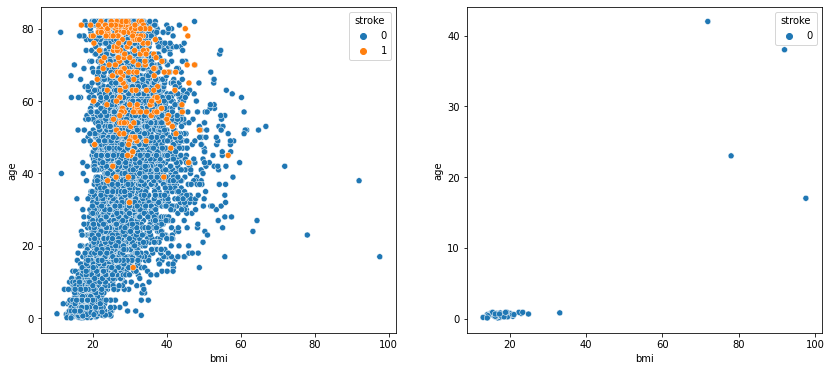

> THESE ARE OUTLIERS:


<ipython-input-93-45550baa8e2d>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[mask_outlier]


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
11371,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0
18837,Male,0.56,0,0,No,children,Urban,98.23,14.1,Unknown,0
14877,Male,0.56,0,0,No,children,Rural,127.23,20.1,Unknown,0
29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
23360,Male,0.80,0,0,No,children,Rural,114.54,15.1,Unknown,0
22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
760,Male,0.80,0,0,No,children,Urban,75.22,33.1,Unknown,0
61836,Female,0.80,0,0,No,children,Urban,106.59,15.5,Unknown,0
68382,Male,0.32,0,0,No,children,Urban,127.78,20.8,Unknown,0


In [93]:
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1

print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", data[mask_outlier].shape[0])

# box and whisker plot
data[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.savefig('./exploration_figures/boxplot_after.png')
pyplot.show()

pyplot.figure(figsize=(14, 6))
data.sort_values('stroke', inplace=True)
pyplot.subplot(1, 2, 1)
seaborn.scatterplot(data=data, x='bmi', y='age', hue='stroke')
pyplot.subplot(1, 2, 2)
seaborn.scatterplot(data=data[mask_outlier], x='bmi', y='age', hue='stroke')
pyplot.show()

print("> THESE ARE OUTLIERS:")
data[mask_outlier]




## Oversampling and Undersampling effect on Data Distribution

View different oversampling techniques change our class distribution with ratio 0.3, i.e
$$\frac{\# \text{stroke}}{\# \text{not stroke}} = \frac{3}{10}$$

Run the code block below

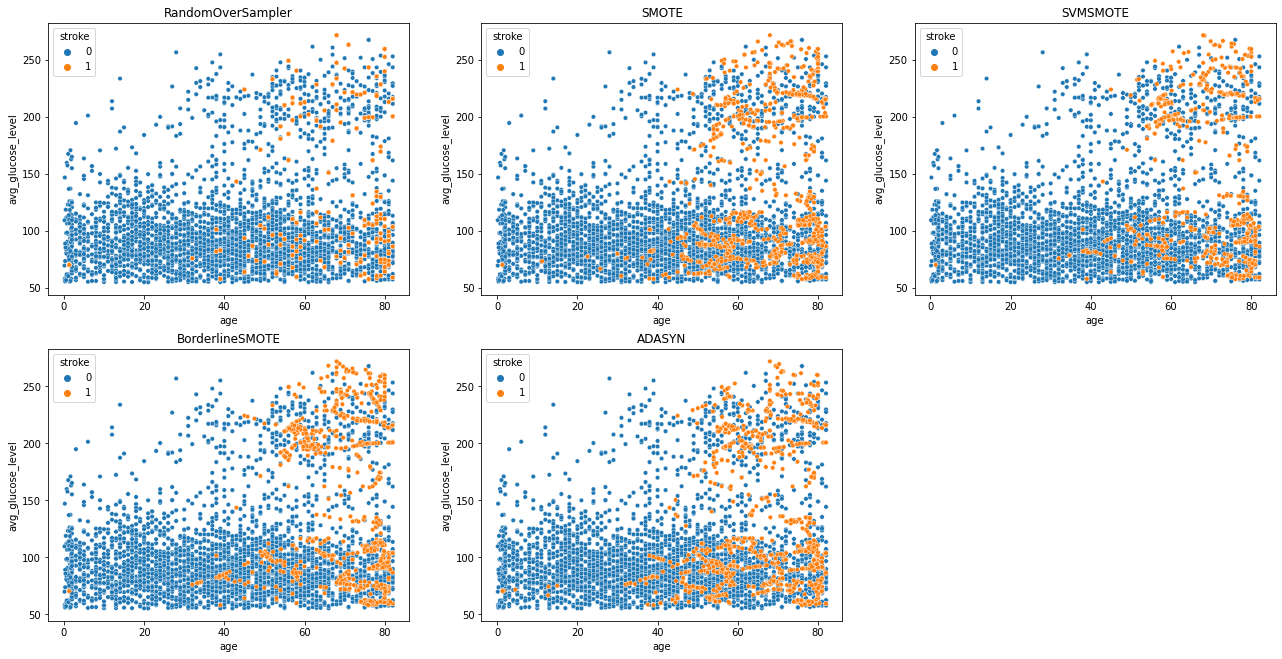

In [100]:


transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

models = [Pipeline([('Trans', transformer),
                  ('RandomOverSampler', RandomOverSampler(sampling_strategy=0.3, random_state=1))]),
          Pipeline([('Trans', transformer),
                  ('SMOTE', SMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('SVMSMOTE', SVMSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('BorderlineSMOTE', BorderlineSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('ADASYN', ADASYN(sampling_strategy=0.3))])
          ]

pyplot.figure(figsize=(22, 11))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(2, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig('./exploration_figures/oversampling.png')
pyplot.show()

View how different undersampling techniques changes our class distribution.

Run the code block below

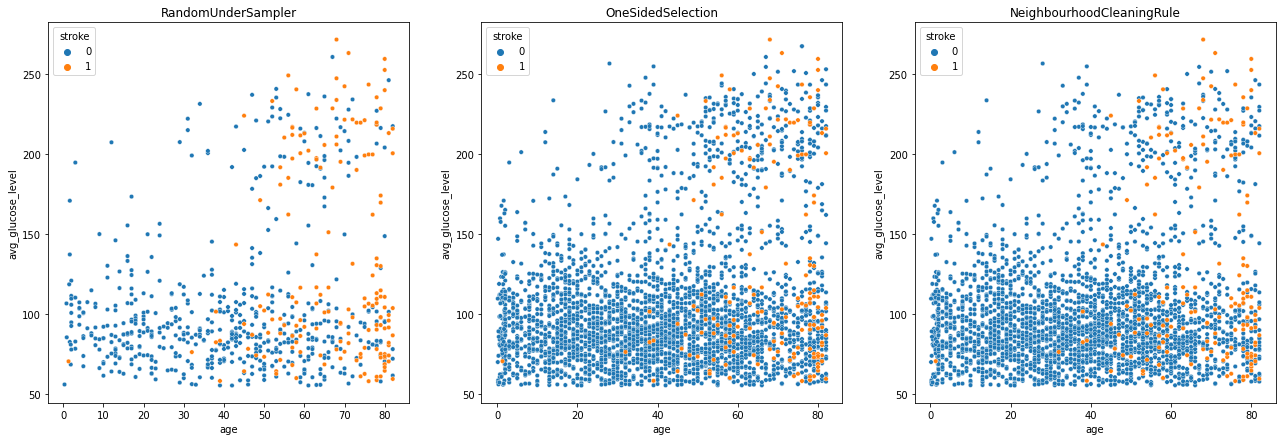

In [101]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))

models = [
          Pipeline([step_trans,
                  ('RandomUnderSampler', RandomUnderSampler(sampling_strategy=0.3))]),
          Pipeline([step_trans,
                  ('OneSidedSelection', OneSidedSelection())]),
          Pipeline([step_trans,
                  ('NeighbourhoodCleaningRule', NeighbourhoodCleaningRule())])
          ]

pyplot.figure(figsize=(22, 7))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("./exploration_figures/undersampling.png")
pyplot.show()




## 4.6 SMOTE + Tomek Links and SMOTE + Edited Nearest Neighbour

Run the code block below to see how `SMOTETomek` and `SMOTEENN` change class distribution.

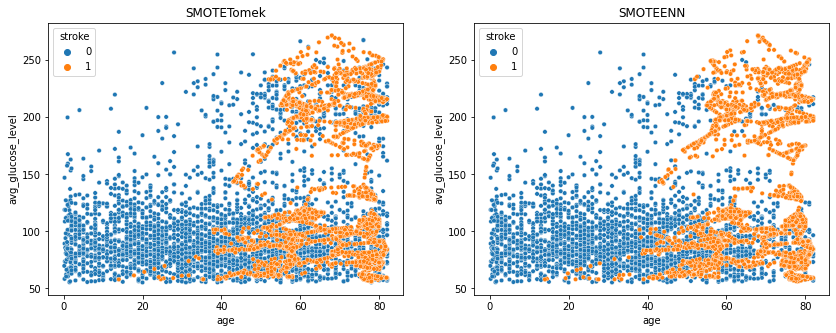

In [102]:
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'])

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier())

models = [Pipeline([step_trans,
                  ('SMOTETomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')))]),
          Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')))])
          ]

pyplot.figure(figsize=(14, 5))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 2, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("./exploration_figures/standard_combine.png")
pyplot.show()

